# My First Autoencoder

The purpose of this small project is not to develop some SOTA, ground-breaking autoencoder which is able to learn effective representations, but rather just to experiment a bit with what they are, what the architecture is, and what it gives.

At this point, I have not watched any videos or read any papers on autoencoders. However, I have seen rough diagrams of the design and this is what I'm trying to recreate.

## Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

## Auxillary Functions

In [2]:
def printf(string, terminal = False):
    # function for printing stuff that gets removed from the output each iteration
    import sys
    if terminal:
        sys.stdout.write("\r")
        sys.stdout.write(string)
        sys.stdout.flush()
    else:
        from IPython.display import display, clear_output
        clear_output(wait = True)
        print(string, end = '')
        sys.stdout.flush()


## Transformations and Data

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

batch_size = 30

train_dataset = torchvision.datasets.MNIST('../torch_data', train = True, transform = transform, download = True)
test_dataset = torchvision.datasets.MNIST('../torch_data', train = False, transform = transform, download = True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

## Model

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.fc1 = nn.Linear(28 * 28, 588)
        self.bn1 = nn.BatchNorm1d(588)
        self.fc2 = nn.Linear(588, 441)
        self.bn2 = nn.BatchNorm1d(441)
        
        # Decoder
        self.fc3 = nn.Linear(441, 588)
        self.bn3 = nn.BatchNorm1d(588)
        self.fc4 = nn.Linear(588, 28 * 28)
        self.bn4 = nn.BatchNorm1d(28 * 28)
        
        self.activation = nn.ReLU()
        self.batch_size = None
    
    def encode(self, x):
        '''
        Takes input and passes it through two fully-connected 
        layers with batch normalisation and relu applied.
        '''
        x = x.reshape(self.batch_size, -1)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.activation(x)
        return x
    
    def decode(self, x):
        '''
        Same as the encoder.
        '''
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.activation(x)
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.activation(x)
        x = x.reshape(self.batch_size, 1, 28, 28)
        return x
    
    def forward(self, x, encode = False, decode = False):
        self.batch_size = x.shape[0]
        if encode:
            return self.encode(x).reshape(self.batch_size, 1, 21, 21)
        if decode:
            return self.decode(x)
        x = self.encode(x)
        x = self.decode(x)
        return x

## Training

In [ ]:
encoder = Autoencoder().to(device)
optimizer = torch.optim.SGD(encoder.parameters(), lr = 0.01)

losses = []
avg_losses = []

n_epochs = 50
for epoch in range(n_epochs):
    epoch_loss = 0
    for f, _ in train_loader:
        f = f.to(device)
        
        # Forward pass
        outputs = encoder(f)
        loss = nn.MSELoss()(f, outputs)
        epoch_loss += loss.item()
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    printf(f'Epoch: {epoch}, Epoch Loss: {epoch_loss:.4f}, Avg Loss: {epoch_loss / len(train_loader):.4f}')
    
    # Keeping track of the loss values
    losses.append(epoch_loss)
    avg_losses.append(epoch_loss / len(train_loader))

In [5]:
# Saving the autoencoder
# torch.save(encoder.state_dict(), 'models/encoder1.pt')

# Loading the autoencoder
encoder = Autoencoder().to(device)
encoder.load_state_dict(torch.load('models/encoder1.pt'))

<All keys matched successfully>

## Evaluation

It is pretty clear to me that the model can continue training as its loss is still decreasing. However, I have not yet done any validation evaluation.

EDIT: Might be worthwhile to try a different weight initialisation since these plots look like they're flat-lining.

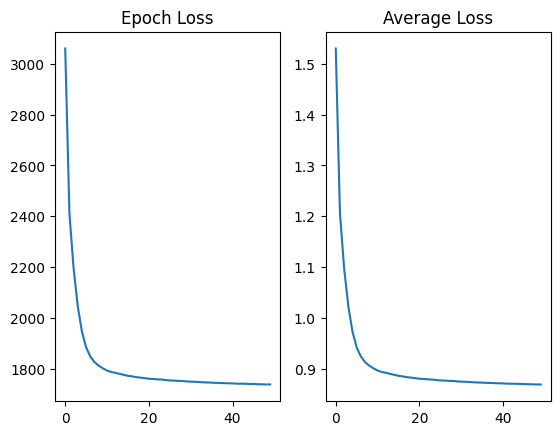

In [10]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(torch.arange(len(losses)), losses)
axs[1].plot(torch.arange(len(losses)), avg_losses)
axs[0].set_title('Epoch Loss')
axs[1].set_title('Average Loss')
plt.show()

## Test evaluation

Looks pretty good to me. The test MSE is slightly lower than the training error. I am conscious of MSE not being the perfect loss function though.

In [33]:
with torch.no_grad():
    encoder.eval()
    loss = 0
    for i, (tf, _) in enumerate(test_loader):
        tf = tf.to(device)
        outputs = encoder(tf)
        loss += nn.MSELoss()(tf, outputs)
    print(f"Average Test Loss: {loss / (i + 1):.4f}")
        

Average Test Loss: 0.8638


## Inner workings

In [8]:
# Retrieves encoded and decoded images
features, _ = next(iter(test_loader))
features = features.to(device)
encoder_output = encoder(features, encode = True).cpu().detach()
encoder_decoder_output = encoder(features).cpu().detach()
features = features.cpu().detach()

I'd say that this plot is very interesting. The recreated image is surprisingly decent, especially considering what the encoding looks like.

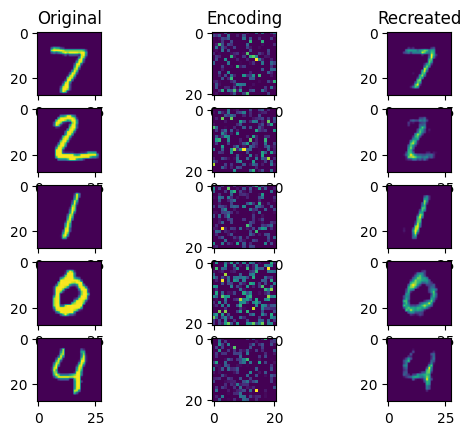

In [9]:
n_examples = 5
fig, axs = plt.subplots(n_examples, 3)

axs[0, 0].set_title('Original')
axs[0, 1].set_title('Encoding')
axs[0, 2].set_title('Recreated')

for i in range(n_examples):
    axs[i, 0].imshow(features[i, 0])
    axs[i, 1].imshow(encoder_output[i, 0])
    axs[i, 2].imshow(encoder_decoder_output[i, 0])

# Training a model to predict labels based on the encodings

## Model

The model is a relatively standard CNN. There are two convolution layers, and one pooling and batch normalisation layer.

In [6]:
class StandardConvnet(nn.Module):
    def __init__(self):
        super(StandardConvnet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4) 
        # width and height become: ((21 - 4 + 2 * padding) /  1) + 1 = 18
        # size: [batch_size, 32, 18, 18]
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # size: [batch_size, 32, 9, 9]
        self.bn = nn.BatchNorm2d(num_features=32)
        self.activation = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5) 
        # width and height become: ((9 - 5 + 2 * 0) /  1) + 1 = 5
        # size: [batch_size, 64, 5, 5]
        self.fc = nn.Linear(in_features=64 * 5 * 5, out_features=10)
        # size: [batch_size, 1600]
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.bn(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x
    
def evaluation(model, encoder = None, test = True):
    '''
    Goes through the train or test datasets and returns 
    the corresponding classification accuracy.
    '''
    with torch.no_grad():
        model.eval()
        
        n_correct, n_total = 0, 0
        for features, labels in test_loader if test else train_loader:
            features, labels = features.to(device), labels.to(device)
            
            if encoder is not None:
                features = encoder(features, encode = True)
            
            outputs = model(features).argmax(dim = -1)
            n_correct += (outputs == labels).sum()
            n_total += len(labels)
    return (n_correct / n_total).item()

In [7]:
classifier = StandardConvnet().to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

train_accuracies = []
validation_accuracies = []

n_epochs = 30
for epoch in range(n_epochs):
    epoch_loss = 0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        
        # Encoding
        with torch.no_grad():
            encoder.eval()
            features_encoded = encoder(features, encode = True).detach()        
        
        # Forward pass
        outputs = classifier(features_encoded)
        loss = criterion(outputs, labels) # (input, target)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    printf(f'Epoch: {epoch + 1}/{n_epochs}, Epoch loss: {epoch_loss:.4f}, Avg loss: {epoch_loss / len(train_loader):.4f}')
    
    train_accuracies += [evaluation(model = classifier, encoder = encoder, test = False)]
    validation_accuracies += [evaluation(model = classifier, encoder = encoder, test = True)]

Epoch: 30/30, Epoch loss: 787.0323, Avg loss: 0.3935

It's very interesting to see what happens to to both the training and validation accuracies. They both follow each other quite strongly. It is a little strange that the training and validation accuracy starts off so high and only seems to get worse as training continues. We would expect at least the training data to be memorised, however, this doesn't seem to be the case.

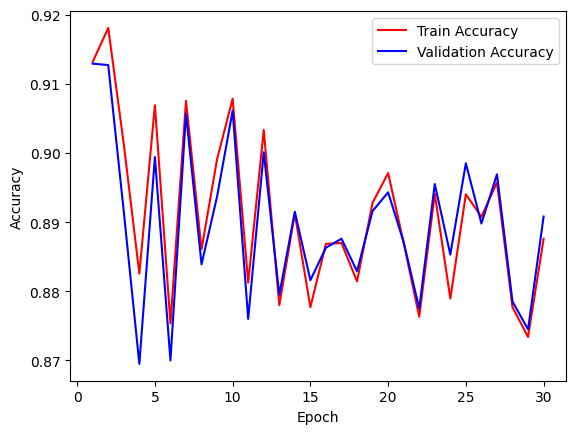

In [11]:
plt.plot(torch.arange(n_epochs) + 1, train_accuracies, color = 'red')
plt.plot(torch.arange(n_epochs) + 1, validation_accuracies, color = 'blue')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(['Train Accuracy', "Validation Accuracy"], loc = 'upper right')
plt.show()